In [134]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [135]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_train.head(2)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative


In [136]:
## drpping na values
df_train.dropna(inplace=True)
print("Shape of the train data: ", df_train.shape)

Shape of the train data:  (27480, 4)


In [137]:
from datasets import Dataset

df_train.reset_index(drop=True,inplace=True)
data = Dataset.from_pandas(df_train)

In [138]:
n_best = 20

def predict_answers(inputs):
    predicted_answer = []
    for i in range(len(inputs["offset_mapping"])):
        start_logit = inputs["start_logits"][i]
        end_logit = inputs["end_logits"][i]
        context = inputs["text"][i]
        offset = inputs["offset_mapping"][i]
        start_indexes = np.argsort(start_logit)[-1: -n_best - 1:-1].tolist()
        end_indexes = np.argsort(end_logit)[-1: -n_best - 1: -1].tolist()
        
        flag = False
        for start_index in start_indexes:
            for end_index in end_indexes:
                # skip answer that are not in the context.
                if offset[start_index] is None or offset[end_index] is None:
                    continue
                # skip answer with length that is either < 0
                if end_index < start_index:
                    continue
                flag = True
                answer = context[offset[start_index][0]: offset[end_index][1]]
                predicted_answer.append(answer)
                break
            if flag:
                break
        if not flag:
            predicted_answer.append(answer)
    return {"predicted_answer":predicted_answer}

In [139]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

## 1. Using the best model: Roberta to predict on the whole dataset.

In [140]:
from transformers import AutoTokenizer
from transformers import TFAutoModelForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained("saved_models/roberta-base/roberta_base_tokenizer",local_files_only=True)

model = TFAutoModelForQuestionAnswering.from_pretrained("saved_models/roberta-base/roberta_base",local_files_only=True)


All model checkpoint layers were used when initializing TFRobertaForQuestionAnswering.

All the layers of TFRobertaForQuestionAnswering were initialized from the model checkpoint at saved_models/roberta-base/roberta_base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForQuestionAnswering for predictions without further training.


In [141]:
MAX_LENGTH = 105

def post_porocess_data(examples):
  questions = examples["sentiment"]
  context = examples["text"]
  inputs = tokenizer(
      questions,
      context,
      max_length = MAX_LENGTH,
      padding="max_length",
      return_offsets_mapping = True,   
  )

  for i in range(len(inputs["input_ids"])):
    offset = inputs["offset_mapping"][i]
    sequence_ids = inputs.sequence_ids(i)
    inputs["offset_mapping"][i] = [
                                  o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
    ]
  return inputs

In [142]:
processed_data = data.map(
    post_porocess_data,
    batched = True
)
processed_data

  0%|          | 0/28 [00:00<?, ?ba/s]

Dataset({
    features: ['attention_mask', 'input_ids', 'offset_mapping', 'selected_text', 'sentiment', 'text', 'textID'],
    num_rows: 27480
})

In [143]:
tf_dataset = processed_data.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    shuffle=False,
    batch_size=16,
)

In [144]:
outputs = model.predict(tf_dataset)

start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [145]:
processed_data.set_format("pandas")
processed_df =  processed_data[:]

processed_df["start_logits"] = start_logits.tolist()
processed_df["end_logits"] = end_logits.tolist()

processed_df["text"] = data["text"]

roberta_final_data = Dataset.from_pandas(processed_df)

roberta_final_data = roberta_final_data.map(predict_answers,batched=True)
roberta_final_data

  0%|          | 0/28 [00:00<?, ?ba/s]

Dataset({
    features: ['attention_mask', 'end_logits', 'input_ids', 'offset_mapping', 'predicted_answer', 'selected_text', 'sentiment', 'start_logits', 'text', 'textID'],
    num_rows: 27480
})

In [146]:
# calculating the jaccard score
score = 0
predicted_answers_by_roberta = roberta_final_data["predicted_answer"]
theoritcal_answers = data["selected_text"]
for i in range(len(theoritcal_answers)):
    score += jaccard(theoritcal_answers[i],predicted_answers_by_roberta[i])

score /= len(theoritcal_answers)
print("Jaccard score on validation data: ", score)

Jaccard score on validation data:  0.7919860485290353


## 2. Error analysis

In [147]:
roberta_final_data.set_format("pandas")
final_data =  roberta_final_data[:]
final_data.head(2)

,attention_mask,end_logits,input_ids,offset_mapping,predicted_answer,selected_text,sentiment,start_logits,text,textID
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-5.651948928833008, -7.115287780761719, -5.18...","[0, 12516, 2, 2, 38, 12905, 417, 33, 2334, 6, ...","[None, None, None, None, [1, 2], [2, 3], [3, 4...","I`d have responded, if I were going","I`d have responded, if I were going",neutral,"[-6.200232982635498, -6.917436122894287, -5.97...","I`d have responded, if I were going",cb774db0d1
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-6.003640174865723, -7.3557257652282715, -5.6...","[0, 33407, 2, 2, 407, 3036, 208, 2606, 38, 40,...","[None, None, None, None, [1, 3], [3, 5], [6, 7...",SAD,Sooo SAD,negative,"[-6.560288906097412, -7.023008823394775, -6.40...",Sooo SAD I will miss you here in San Diego!!!,549e992a42


### 2.1. Divide the dataset sentiment wise.

In [148]:
df_positive = final_data[final_data["sentiment"] == "positive"]
df_negative = final_data[final_data["sentiment"] == "negative"]
df_neutral = final_data[final_data["sentiment"] == "neutral"]

print("Shape of the df_positive shape: ", df_positive.shape)
print("Shape of the df_negative_shape: ", df_negative.shape)
print("Shape of the df_neutral shape: ", df_neutral.shape)


Shape of the df_positive shape:  (8582, 10)
Shape of the df_negative_shape:  (7781, 10)
Shape of the df_neutral shape:  (11117, 10)


### 2.2 Computing Jaccard score between predicted answer and the ground truth answer.

In [149]:
df_positive["jaccard_score"] = df_positive.apply(lambda x: jaccard(x["selected_text"],x["predicted_answer"]),axis=1)
df_negative["jaccard_score"] = df_negative.apply(lambda x: jaccard(x["selected_text"],x["predicted_answer"]),axis=1)
df_neutral["jaccard_score"] = df_neutral.apply(lambda x: jaccard(x["selected_text"],x["predicted_answer"]),axis=1)



<ipython-input-149-a656a6ec807d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positive["jaccard_score"] = df_positive.apply(lambda x: jaccard(x["selected_text"],x["predicted_answer"]),axis=1)
<ipython-input-149-a656a6ec807d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_negative["jaccard_score"] = df_negative.apply(lambda x: jaccard(x["selected_text"],x["predicted_answer"]),axis=1)
<ipython-input-149-a656a6ec807d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

### 2.3 Distribution of Jaccard score sentiment wise.

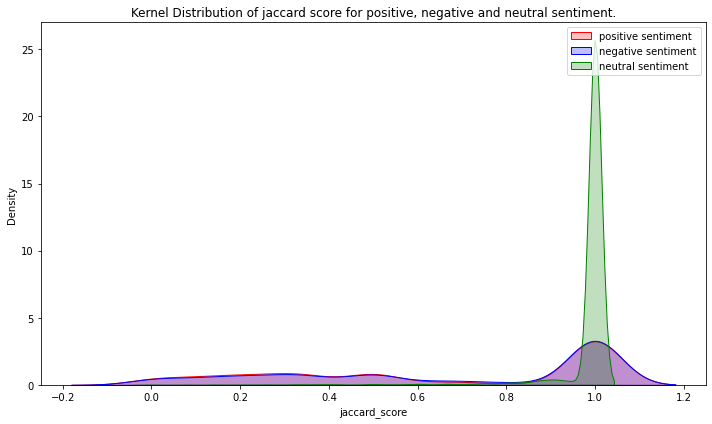

In [150]:
fig, (ax1) = plt.subplots(1,1,figsize=(10,6))

sns.kdeplot(df_positive["jaccard_score"],shade=True,color="r",ax=ax1).set_title("Kernel Distribution of jaccard score for positive, negative and neutral sentiment.")
sns.kdeplot(df_negative["jaccard_score"],shade=True,color="b",ax=ax1)
sns.kdeplot(df_neutral["jaccard_score"],shade=True,color="g",ax=ax1)

ax1.legend(["positive sentiment","negative sentiment","neutral sentiment"],loc = "upper right")

plt.tight_layout()
plt.show()


### Observation(s)

- As we can observe, distrbution of jaccard score for neutral sentimet is symmentrical and is centred around 1.0. This means that predicted and ground truth answers are almost identical for neutral sentiment.
- Where as. distribution of jaccard score for positive and negative sentiment is asymmetrical(left skewed) and highly overlapping. 

### 2.4 Error Analsis of  positive sentiment samples with low jaccard score.

In [151]:
## get rows who's jaccard score is less than 0.5

df_positive_errors = df_positive[df_positive["jaccard_score"]<0.5]

print("Number of rows who's jaccard score for positive sentiment is less than 0.5: ", df_positive_errors.shape[0])


Number of rows who's jaccard score for positive sentiment is less than 0.5:  2920


In [152]:
## Let's see the context

count=0
for i in range(df_positive_errors.shape[0]):
    count+=1
    print("*"*100)
    print("Context: ",df_positive_errors["text"].iloc[i])
    print("Ground Truth answer: ",df_positive_errors["selected_text"].iloc[i])
    print("Predicted answer: ", df_positive_errors["predicted_answer"].iloc[i])
    print("*"*100)
    if count==20:
        break

****************************************************************************************************
Context:  the free fillin` app on my ipod is fun, im addicted
Ground Truth answer:  the free fillin` app on my ipod is fun, im addicted
Predicted answer:  fun,
****************************************************************************************************
****************************************************************************************************
Context:   That`s very funny.  Cute kids.
Ground Truth answer:  funny.
Predicted answer:  That`s very funny.
****************************************************************************************************
****************************************************************************************************
Context:  A little happy for the wine jeje ok it`sm my free time so who cares, jaja i love this day
Ground Truth answer:  A little happy fo
Predicted answer:  happy for the wine jeje ok it`sm my free time so who cares, jaja i 

### 2.5 Error Analsis of  negative sentiment samples with low jaccard score.

In [155]:
## get rows who's jaccard score is less than 0.5

df_negative_errors = df_negative[df_negative["jaccard_score"]<0.5]

print("Number of rows who's jaccard score for negative sentiment is less than 0.5: ", df_negative_errors.shape[0])


Number of rows who's jaccard score for negative sentiment is less than 0.5:  2472


In [154]:
## Let's see the context 

count=0
for i in range(df_negative_errors.shape[0]):
    count+=1
    print("*"*100)
    print("Context: ",df_negative_errors["text"].iloc[i])
    print("Ground Truth answer: ",df_negative_errors["selected_text"].iloc[i])
    print("Predicted answer: ", df_negative_errors["predicted_answer"].iloc[i])
    print("*"*100)
    if count==20:
        break

****************************************************************************************************
Context:  Uh oh, I am sunburned
Ground Truth answer:  Uh oh, I am sunburned
Predicted answer:  sunburned
****************************************************************************************************
****************************************************************************************************
Context:  is back home now      gonna miss every one
Ground Truth answer:  onna
Predicted answer:  gonna miss
****************************************************************************************************
****************************************************************************************************
Context:    I`m sorry.
Ground Truth answer:  I`m sorry.
Predicted answer:  I`m sorry
****************************************************************************************************
**********************************************************************************************

### Observation(s):

- The Roberta model correctly able to to find the word from the context that reflect the correspoding sentiment(question) but sometimes it fails to get the phrase from the context.


| Context | Sentiment | Given Answers | Roberta predicted Answers |
|---------|-----------|-----------    |-------------------|
| the free fillin` app on my ipod is fun, im addicted  |  positive | the free fillin` app on my ipod is fun, im addicted                   |            fun,       |
|     Happy Star Wars day everyone! and Enjoy the holiday (UK)    |  positive |Happy Star Wars day everyone! and Enjoy the holiday (UK)                    |                Happy   |
| which case? I got a new one last week and I`m not thrilled at all with mine. | negative | d I`m not thrilled at all with mine. | not thrilled |
| it is ****...u have dissappointed me that past few days| negative | it is ****...u have dissappointed me that past few days | dissappointed |


- When the given sample contains two or more positive/negative words that reflects the corresponding sentiment(question), the model gets confused in choosing the right word/phrase that is required as an answer.

| Context | Sentiment | Given Answers | Roberta predicted Answers |
|---------|-----------|-----------    |-------------------|
| SWEEEEET - San Fran is awesome!!!!  Love it there |  positive | Love it there              |        awesome!!!!      |
|      Wolverine Was BOSS! Seriously, And Will.I.Am Was In It, What The **** ?? |  negative | Seriously,    |               What The ****  |


| Model | Kaggle Private Leaderboard Score |
|---------|-----------|
| Bert-base |  0.67857 |
|  Albert-base |  0.67573 |
| Roberta-base |  **0.71917** |
|  Xlnet-base |  0.68592 |
|  ensemble(Bert + Albert + Roberta + Xlnet)|  0.68683 |

